In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

SEQ_LEN = 20
N_EPOCHS = 10
BATCH_SIZE = 32

In [2]:
#define model
class StockGRU3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [3]:
#reading and splitting of data
def load_index(path, prefix):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
    df = df.sort_values("Date")
    df = df[(df["Date"].dt.year >= 2020) & (df["Date"].dt.year <= 2024)].reset_index(drop=True)
    df = df[["Date", "Close/Last", "Open", "High", "Low"]]
    df.columns = ["Date"] + [f"{prefix}_{col}" for col in df.columns[1:]]
    return df

sap = load_index("SaP Historical Data 5Y.csv", "SAP")
nas = load_index("NASDAQ-100 (NDX) Historical Data 5Y.csv", "NASDAQ")
dow = load_index("Dow Jones Industrial Average Historical Data 5Y.csv", "DJ")

merged_df = sap.merge(nas, on="Date").merge(dow, on="Date")

features = [col for col in merged_df.columns if col != "Date"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(merged_df[features])

def create_sequences(data, seq_len, target_indices):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_indices])
    return np.array(X), np.array(y)

target_cols = ["SAP_Close/Last", "NASDAQ_Close/Last", "DJ_Close/Last"]
target_indices = [features.index(col) for col in target_cols]

X, y = create_sequences(scaled, SEQ_LEN, target_indices)
dates = merged_df["Date"][SEQ_LEN:].reset_index(drop=True)

train_idx = dates.dt.year <= 2023
test_idx = dates.dt.year == 2024

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [7]:
#training
from itertools import product

hidden_sizes = [64, 128]
learning_rates = [0.001, 0.01]
num_layers_list = [1, 2]

hyperparams_grid = list(product(hidden_sizes, learning_rates, num_layers_list))

results = {}

for HIDDEN_SIZE, LEARNING_RATE, NUM_LAYERS in hyperparams_grid:
    label = f"H{HIDDEN_SIZE}_LR{LEARNING_RATE}_L{NUM_LAYERS}"
    model = StockGRU3(input_size=X.shape[2], hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), BATCH_SIZE, shuffle=True)
    train_losses = []
    for epoch in range(N_EPOCHS):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

    # Predictions
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
        y_actual = y_test_tensor.numpy()
    
        # Prepare empty arrays for full inverse transform (same number of features)
        y_pred_full = np.zeros((len(y_pred), len(features)))
        y_actual_full = np.zeros((len(y_actual), len(features)))
    
        # Fill target columns only (others stay as zero)
        for i, idx in enumerate(target_indices):
            y_pred_full[:, idx] = y_pred[:, i]
            y_actual_full[:, idx] = y_actual[:, i]
    
        # Now inverse transform all features, then slice back to targets
        y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, target_indices]
        y_actual_unscaled = scaler.inverse_transform(y_actual_full)[:, target_indices]


    results[label] = {
        "train_loss": train_losses,
        "pred": y_pred_unscaled,
        "actual": y_actual_unscaled
    }

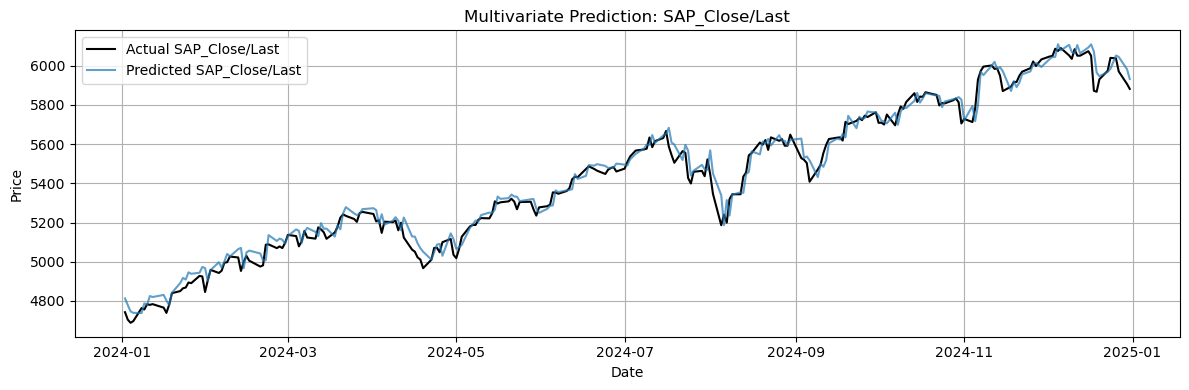

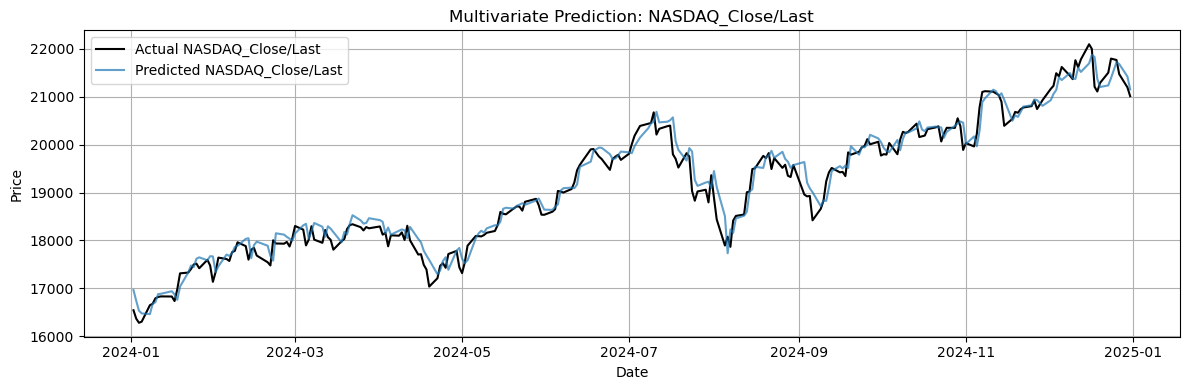

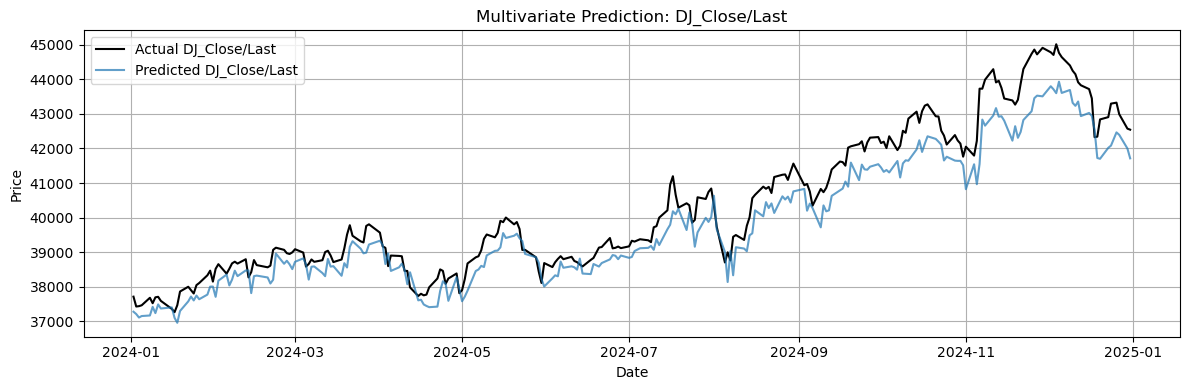

In [9]:
import matplotlib.pyplot as plt

for i, col in enumerate(target_cols):
    plt.figure(figsize=(12, 4))
    plt.plot(dates[test_idx], y_actual_unscaled[:, i], label=f"Actual {col}", color="black")
    plt.plot(dates[test_idx], y_pred_unscaled[:, i], label=f"Predicted {col}", alpha=0.7)
    plt.title(f"Multivariate Prediction: {col}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()